**Autoencoder (AE)**
---
**Imports**

---

External libraries required for operation

In [1]:
import json
import h5py
import os
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import sklearn.metrics as sk

2025-07-22 07:55:01.832459: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 07:55:01.839091: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 07:55:01.854718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753196101.879408 2848634 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753196101.886937 2848634 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753196101.908185 2848634 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Opening the trainer_config.json file:

In [2]:
TRAINER_CONFIG_FILE_LOCATION = 'config/trainer_config.json'
model_type = 'AE'
with open(TRAINER_CONFIG_FILE_LOCATION, 'r') as file:
    train_config = json.load(file)

**Data Preprocessing**

---

This block will open and validate the background data file. It must contain the directory "Particles" within it in order for us to continue. It will then save it into a numpy array to be used for model training.

In [3]:
#Opening file in read mode...
data_file = h5py.File(train_config["data_files"]["background_file"], 'r')



#Checking for validity...
is_file_valid = False
required_dataset = train_config["datasets"]["required_dataset"]
for key in data_file['/']:
    if isinstance(data_file['/' + key], h5py.Dataset) and key == required_dataset:
        is_file_valid = True



#Stop if file is not valid...
if not is_file_valid:
    raise Exception("File Does not contain the required dataset")



#Save it into a numpy array...
preprocessed_data = np.array(data_file[required_dataset])

**Data Splitting**

---

Splitting data into testing, validating and training sets. So that the model is tested and validated with unique data that it was not trained on (prevents overfitting!)

In [4]:

# TODO label
for i, batch in enumerate(preprocessed_data):
    pt_sum = 0
    for j, particle in enumerate(preprocessed_data[i, :, :]):
        if particle[3] != 0:
            pt_sum += particle[0]
    for j, particle in enumerate(preprocessed_data[i, :, :]):
        particle[0] = particle[0] / pt_sum



#Save data_train, data_validate, and data_test (if needed)...
data_train = preprocessed_data[train_config["data_split"]["train_split_start"]:train_config["data_split"]["train_split_end"], :, 0:3].reshape(-1, 57)
data_validate = preprocessed_data[train_config["data_split"]["val_split_start"]:train_config["data_split"]["val_split_end"], :, 0:3].reshape(-1, 57)

### MAY BE COMMENTED OUT IF TEST DATA IS NOT NEEDED!
data_test = preprocessed_data[train_config["data_split"]["test_split_start"]:train_config["data_split"]["test_split_end"], :,0:3].reshape(-1, 57)
###



# Truncate data if there is a max...
if train_config["data_split"]["max_data"] != "None":
    data_test = data_test[:train_config["data_split"]["max_data"]]
    print("Generated The Following Datasets\n Train Data Shape : {}\n Validation Data Shape : {}\n Test Data Shape : {}".format(data_train.shape, data_validate.shape,data_test.shape))
else:
    print("Generated The Following Datasets\n Train Data Shape : {}\n Validation Data Shape : {}\n Test Data Shape : {}".format(data_train.shape, data_validate.shape,data_test.shape))

Generated The Following Datasets
 Train Data Shape : (2000000, 57)
 Validation Data Shape : (399999, 57)
 Test Data Shape : (70000, 57)


**Model Initialization**

---

The Autoencoder Model class:

In [5]:
class AeModel(Model):
    def __init__(self, train_config):
        super(AeModel, self).__init__()
        self.latent_dim = train_config["encoder_design"]["latent_layer_dimension"]
        self.input_shape = (train_config["encoder_design"]["input_layer_dimension"],)

        # Encoder

        #Creating input layer
        self.encoder_input = layers.Input(shape=self.input_shape)
        x = self.encoder_input


        #Creating inner encoder layers:
        ip_layer_dimension_list = train_config["encoder_design"]["inner_layer_dimensions"]
        for dimension in ip_layer_dimension_list:
            x = layers.Dense(dimension, activation='relu', name=f"encoder_{dimension}")(x)

        #Creating the latent space layer
        self.z = layers.Dense(self.latent_dim, activation='relu', name="latent")(x)

        # Decoder

        #Creating decoder input layer (same as latent dim)
        self.decoder_input = layers.Input(shape=(self.latent_dim,))
        x = self.decoder_input

        #Creating inner decoder layers
        op_layer_dimension_list = train_config["decoder_design"]["inner_layer_dimensions"]
        for dimension in op_layer_dimension_list:
            x = layers.Dense(dimension, activation='relu')(x)

        #Creating output layer
        self.decoder_output = layers.Dense(self.input_shape[0], activation='sigmoid')(x)
        #Note: Swapped the order on config.json, if there are issues with this line of code switch the order of 16, 32 back to 32, 16.


        # Combine encoder and decoder
        self.encoder = Model(self.encoder_input, self.z, name="encoder")
        self.encoder.summary()
        self.decoder = Model(self.decoder_input, self.decoder_output, name="decoder")
        self.decoder.summary()

        # Full autoencoder model
        full_input = self.encoder_input
        encoded = self.encoder(full_input)
        decoded = self.decoder(encoded)
        self.autoencoder = Model(full_input, decoded, name="autoencoder")

    # default: model.compile(optimizer='adam', loss='mse')
    def call(self, inputs):
        return self.autoencoder(inputs)


Initialize an instance of the above class

In [6]:
model = AeModel(train_config)

2025-07-22 07:56:47.504162: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 57)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_32 (Dense)              │ (None, 32)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_16 (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435 (9.51 KB)

 Trainable params: 2,435 (9.51 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,489 (9.72 KB)

 Trainable params: 2,489 (9.72 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

---

In [7]:
early_stopping = EarlyStopping(patience=train_config["hyperparameters"]["stop_patience"], restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=train_config["hyperparameters"]["lr_patience"], verbose=1)

model.compile(optimizer=Adam(), loss=tf.keras.losses.MeanSquaredError())
history = model.fit(x=data_train,
                        y=data_train,
                        validation_data=(data_validate, data_validate),
                        epochs=train_config["hyperparameters"]["epochs"],
                        batch_size=train_config["hyperparameters"]["batch_size"],
                        # callbacks=[early_stopping, reduce_lr, training_logger, tensorboard_callback]
                        )

Epoch 1/3
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.2049 - val_loss: 0.1576
Epoch 2/3
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1547 - val_loss: 0.1511
Epoch 3/3
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1511 - val_loss: 0.1496


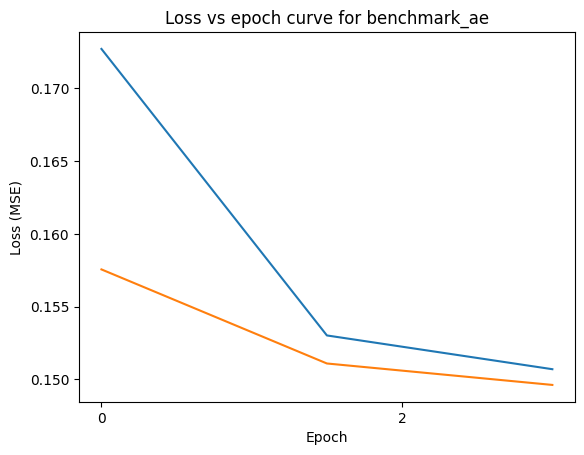

In [8]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title("Loss vs epoch curve for " + train_config["model_files"]["model_name"])
plt.xticks(np.arange(0,21,2))
plt.plot(np.linspace(0, train_config["hyperparameters"]["epochs"], train_config["hyperparameters"]["epochs"]), loss)
plt.plot(np.linspace(0, train_config["hyperparameters"]["epochs"], train_config["hyperparameters"]["epochs"]), val_loss)

plt.savefig(os.path.join(train_config["outputs"]["graph_directory"], datetime.datetime.now().strftime(
    train_config["outputs"]["date_time_format"]) + "_LossVsEpoch.png"), format="png", bbox_inches="tight")
plt.show()

**Model Evaluation**

---

Processing the signal data

In [14]:
#Opening file in read mode...
file_name = "Ato4l_lepFilter_13TeV"
signal_file = h5py.File(train_config["data_files"][file_name], 'r')



#Checking for validity...
is_file_valid = False
required_dataset = train_config["datasets"]["required_dataset"]
for key in signal_file['/']:
    if isinstance(signal_file['/' + key], h5py.Dataset) and key == required_dataset:
        is_file_valid = True



#Stop if file is not valid...
if not is_file_valid:
    raise Exception("File Does not contain the required dataset")



#Save it into a numpy array...
signal_data = np.array(signal_file[required_dataset])

for i, batch in enumerate(signal_data):
    pt_sum = 0
    for j, particle in enumerate(signal_data[i, :, :]):
        if particle[3] != 0:
            pt_sum += particle[0]
    for j, particle in enumerate(signal_data[i, :, :]):
        particle[0] = particle[0] / pt_sum
signal_data = signal_data[:, :,0:3].reshape(-1, 57)



reconstructed_background = model(data_test).numpy()
reconstructed_signal = model(signal_data).numpy()

background_scores = np.mean((reconstructed_background - data_test)**2,axis=1)
signal_scores = np.mean((reconstructed_signal - signal_data)**2, axis=1)

truth_values = np.concatenate([
    np.zeros(len(background_scores)),
    np.ones(len(signal_scores))
])
scores = np.concatenate([
    background_scores, 
    signal_scores
])

Generate AUC and loss histograms, seeing if we can get that anomaly score to work...

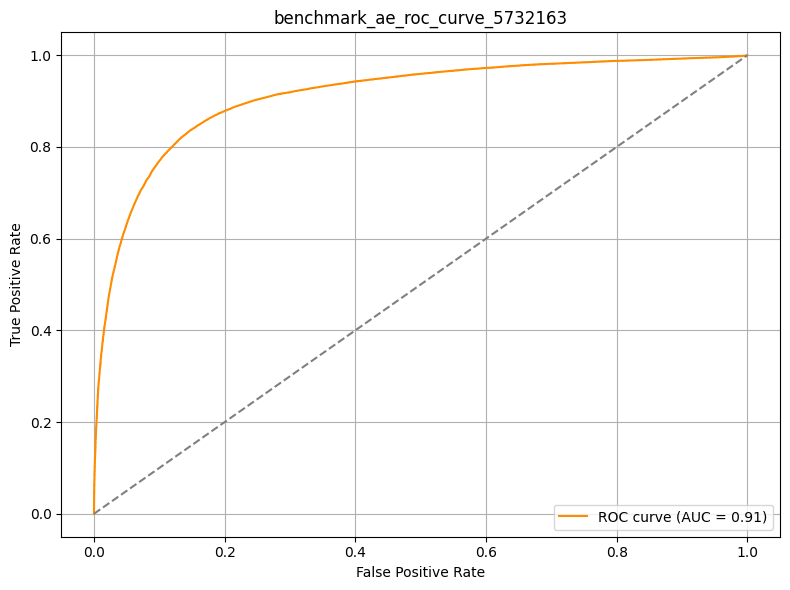

In [18]:
fpr, tpr, _ = sk.roc_curve(truth_values, scores)
roc_auc = sk.auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('benchmark_ae_roc_curve_5732163')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(train_config["outputs"]["graph_directory"], datetime.datetime.now().strftime(
    train_config["outputs"]["date_time_format"]) + "_ROC.png"), format="png", bbox_inches="tight")
plt.show()

